In [8]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from lib.functions import LogisticRegression
import lib.load_datasets as load_datasets
from compressors.markov_compressors import *
from compressors.other_compressors import *
from lib.gradient_descent import *

In [9]:
X, y = load_datasets.load_libxvm('mushrooms.libxvm', normalize=True, n_features=120)
y -= np.ones_like(y)
# X, y = make_blobs(n_samples=500, centers=2, n_features=5, random_state=0)
function = LogisticRegression(X, y, regularization='l2')
dim = function.getDimension()
alpha = 0.0000000001 # for diabetes
# alpha = 0.04 # for make_blobs
print(dim)

113


In [20]:
experiments = [
    compressedGD(function, compressor=NoneCompressor(dim=dim), alpha=alpha, max_iter=1000000),
    # compressedGD(function, compressor=BanLastMCompressor(dim=dim, alpha=0.1, M=9), alpha=alpha, max_iter=1000),
    # compressedGD(function, compressor=RandKCompressor(dim=dim, alpha=0.1), alpha=alpha, max_iter=1000),
    # compressedGD(function, compressor=MultiplicationPenaltyCompressor(dim=dim, alpha=0.1, penalty=0.7), alpha=alpha, max_iter=10000),
    # compressedGD(function, compressor=SubtractionPenaltyCompressor(dim=dim, alpha=0.1, penalty=0.25), alpha=alpha, max_iter=10000),
    # compressedGD(function, compressor=SubtractionPenaltyCompressor(dim=dim, alpha=0.1, penalty=0.5), alpha=alpha, max_iter=10000),
    # compressedGD(function, compressor=ExpSmoothingCompressor(dim=dim, alpha=0.1, beta=0.2), alpha=alpha, max_iter=10000),
]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 659557/1000000 [8:00:05<4:07:48, 22.90it/s]


KeyboardInterrupt: 

In [22]:
experiments.sort(key=lambda exp : exp['coords'][-1])

table = [
    ["compression", "num_iter", "transmitted coordinates"],
    *[
        [exp['name'], exp['num_iter'], exp['coords'][-1]]
        for exp in experiments
    ]
]
print(tabulate(table))

-------------------  --------  -----------------------
compression          num_iter  transmitted coordinates
Without compression  100000    11300000
-------------------  --------  -----------------------


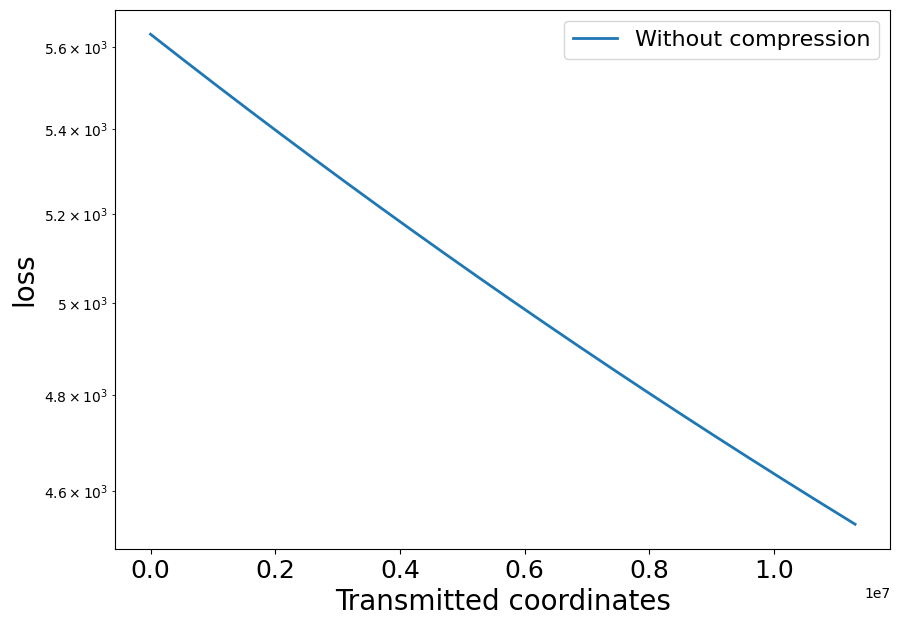

In [23]:
plt.figure(figsize=(10, 7))
for exp in experiments:
    plt.semilogy(
        exp['coords'],
        [-loss for loss in exp['loss']],
        label=exp['name'],
        linewidth=2
    )
plt.legend(loc="best", fontsize=16)
plt.xlabel(r"Transmitted coordinates", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)